In [ ]:
!pip uninstall -y transformers tokenizers -q

!pip install --no-cache-dir "transformers==4.43.3" "peft==0.11.1" "accelerate==0.30.1"
!pip install --no-cache-dir datasets bert-score textstat
!pip install --no-cache-dir sentencepiece
!pip install --no-cache-dir alignscore-SpeedOfMagic spacy nltk
!python -m spacy download en_core_web_sm

import nltk
nltk.download("punkt")
nltk.download("punkt_tab")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 364.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 292.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 200.8 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.11.0
    Uninstalling accelerate-1.11.0:
      Successfully uninstalled accelerate-1.11.0
  Attempting uninstall: peft
    Found existing installation: peft 0.18.0
    Uninstalling peft-0.18.0:
      Successfully uninstalled peft-0.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 375.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import os
os.environ["BITSANDBYTES_NOWELCOME"] = "1"
os.environ["BITSANDBYTES_DISABLE"] = "1"
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

In [ ]:
import os
import zipfile
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Any

import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)
from peft import LoraConfig, get_peft_model

from bert_score import score as bert_score
import textstat
from alignscore import AlignScore


ZIP_PATH = "/content/training_data.zip"
ROOT_DATA_DIR = "/content/training_data"
TRAINING_DATA_PATH = "/content/training_data/training_data"

BASE_MODEL_ID = "Qwen/Qwen2.5-3B-Instruct"
ADAPTER_DIR = "/content/qwen2.5-3b-pls"

os.makedirs(ROOT_DATA_DIR, exist_ok=True)


if os.path.exists(ZIP_PATH):
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(ROOT_DATA_DIR)
    print("Datos extraídos en:", ROOT_DATA_DIR)
else:
    print("No encontré training_data.zip")


for root, dirs, files in os.walk("/content"):
    level = root.replace("/content", "").count(os.sep)
    indent = " " * (2 * level)
    print(f"{indent}{os.path.basename(root)}")
    for f in files:
        print(f"{indent}  - {f}")
    if level >= 2:
        break

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Datos extraídos en: /content/training_data
content
  - training_data.zip
  .config
    - .last_opt_in_prompt.yaml
    - .last_survey_prompt.yaml
    - .last_update_check.json
    - hidden_gcloud_config_universe_descriptor_data_cache_configs.db
    - config_sentinel
    - active_config
    - gce
    - default_configs.db
    configurations
      - config_default
Device: cuda


In [ ]:
@dataclass
class PromptPair:
    medical: str
    plain: str
    context: str | None = None
    pair_id: str | None = None
    flesch_score: float | None = None


def normalize_doc_id(doc_id: str) -> str:
    s = str(doc_id)
    if "_" in s:
        s = s.split("_")[00]
    s = s.replace("-abstract", "").replace("-pls", "")
    return s


def load_cochrane_pairs(training_data_path: str | Path):
    training_data_path = Path(training_data_path)

    print("\n=== DEBUG RUTA DE DATOS ===")
    print("training_data_path:", training_data_path)
    if training_data_path.exists():
        print("Contenido de la carpeta:", os.listdir(training_data_path))
    else:
        print("Ruta no existe")

    parquet_files = [
        "main_train.parquet",
        "main_test.parquet",
        "augmented_train.parquet",
        "augmented_test.parquet",
        "no_pls_clean.parquet",
        "pls_clean.parquet",
    ]

    all_rows = []

    print("\nLeyendo archivos y agrupando por doc_id normalizado...")
    for fname in parquet_files:
        fp = training_data_path / fname
        if not fp.exists():
            print(f" - [OMITIDO] {fname} (no existe en {training_data_path})")
            continue

        df = pd.read_parquet(fp)
        print(f" - [OK] {fname}: {df.shape[0]} filas")
        for col in ["doc_id", "text", "label"]:
            if col not in df.columns:
                raise ValueError(f"{fname} no tiene columna {col}")
        df = df[["doc_id", "text", "label"]].copy()
        df["doc_id_norm"] = df["doc_id"].apply(normalize_doc_id)
        all_rows.append(df)

    if not all_rows:
        raise RuntimeError("No se encontraron datos parquet válidos en la ruta.")

    full_df = pd.concat(all_rows, ignore_index=True)

    grouped = full_df.groupby("doc_id_norm")

    pairs: list[PromptPair] = []
    for doc_id_norm, g in grouped:
        med_candidates = g[g["label"] == "no_pls"]
        plain_candidates = g[g["label"] == "pls"]
        if med_candidates.empty or plain_candidates.empty:
            continue

        med_row = med_candidates.loc[med_candidates["text"].str.len().idxmax()]
        plain_row = plain_candidates.loc[plain_candidates["text"].str.len().idxmax()]

        pairs.append(
            PromptPair(
                medical=str(med_row["text"]),
                plain=str(plain_row["text"]),
                context=None,
                pair_id=doc_id_norm,
            )
        )

    print(f"\nTotal de doc_id (normalizados) con al menos 1 medical y 1 plain: {len(pairs)}")

    import random
    random.seed(42)
    random.shuffle(pairs)

    n_total = len(pairs)
    n_train = int(n_total * 0.70)
    n_val   = int(n_total * 0.15)
    n_test  = n_total - n_train - n_val

    train_pairs = pairs[:n_train]
    val_pairs   = pairs[n_train:n_train + n_val]
    eval_pairs  = pairs[n_train + n_val:]

    print(f"Total de pares construidos: {n_total}")
    print("Split:")
    print(f" - Train: {len(train_pairs)}")
    print(f" - Val:   {len(val_pairs)}")
    print(f" - Test:  {len(eval_pairs)}")

    return train_pairs, val_pairs, eval_pairs


train_pairs, val_pairs, eval_pairs = load_cochrane_pairs(TRAINING_DATA_PATH)
all_pairs = train_pairs + val_pairs + eval_pairs
print(f"\nTotal de pares preparados para RL / LoRA: {len(all_pairs)}")



=== DEBUG RUTA DE DATOS ===
training_data_path: /content/training_data/training_data
Contenido de la carpeta: ['no_pls_clean.parquet', 'main_train.parquet', 'augmented_test.parquet', 'augmented_train.parquet', 'main_test.parquet', 'pls_clean.parquet']

Leyendo archivos y agrupando por doc_id normalizado...
 - [OK] main_train.parquet: 7408 filas
 - [OK] main_test.parquet: 1851 filas
 - [OK] augmented_train.parquet: 16469 filas
 - [OK] augmented_test.parquet: 4120 filas
 - [OK] no_pls_clean.parquet: 8401 filas
 - [OK] pls_clean.parquet: 6778 filas

Total de doc_id (normalizados) con al menos 1 medical y 1 plain: 5688
Total de pares construidos: 5688
Split:
 - Train: 3981
 - Val:   853
 - Test:  854

Total de pares preparados para RL / LoRA: 5688


In [ ]:
INSTRUCTION = (
    "You are a specialist in healthcare communication. "
    "Use the context to transform the following medical text into a clear, concise, "
    "and easy-to-understand summary for a patient and their family. "
    "Retain all relevant clinical data, but explain technical terms using simple language and short sentences.\n\n"
)

import torch
from torch.utils.data import Dataset

class PLSDataset(Dataset):
    def __init__(self, pairs, tokenizer, max_length=2048):
        """
        pairs: lista de PromptPair (medical, plain, ...)
        tokenizer: tokenizer del modelo (Qwen 2.5-3B)
        max_length: longitud máxima del input
        """
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]

        # Prompt de instrucción
        prompt = (
            "You are a specialist in healthcare communication. "
            "Use the context to transform the following medical text into a clear, concise, "
            "and easy-to-understand summary for a patient and their family. "
            "Retain all relevant clinical data, but explain technical terms using simple "
            "language and short sentences.\n\n"
            "### Medical text:\n"
            f"{pair.medical}\n\n"
            "### Simplified summary:\n"
            f"{pair.plain}"
        )

        enc = self.tokenizer(
            prompt,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        input_ids = enc["input_ids"][0]
        attention_mask = enc["attention_mask"][0]

        # Etiquetas = input_ids
        labels = input_ids.clone()
        labels[attention_mask == 0] = -100

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }



In [ ]:
def setup_quantization_config():
    return BitsAndBytesConfig(
        load_in_4bit=False,
        load_in_8bit=False,
    )

def setup_lora_config():
    return LoraConfig(
        r=16,
        lora_alpha=16,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )

print("="*80)
print(f"CARGANDO MODELO BASE {BASE_MODEL_ID}")
print("="*80)

base_tokenizer = AutoTokenizer.from_pretrained(
    BASE_MODEL_ID,
    trust_remote_code=True
)
if base_tokenizer.pad_token is None:
    base_tokenizer.pad_token = base_tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL_ID,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
    quantization_config=None,
)

print("Preparando modelo para LoRA...")
lora_config = setup_lora_config()
model_lora = get_peft_model(base_model, lora_config)
model_lora.print_trainable_parameters()


CARGANDO MODELO BASE Qwen/Qwen2.5-3B-Instruct


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

Preparando modelo para LoRA...
trainable params: 7,372,800 || all params: 3,093,311,488 || trainable%: 0.2383


In [ ]:
train_dataset = PLSDataset(train_pairs, base_tokenizer, max_length=2048)
val_dataset   = PLSDataset(val_pairs,   base_tokenizer, max_length=2048)

print("Tamaño train_dataset:", len(train_dataset))
print("Tamaño val_dataset:", len(val_dataset))

# Verificamos un ejemplo
sample = train_dataset[0]
for k, v in sample.items():
    print(k, v.shape, v.dtype)


Tamaño train_dataset: 3981
Tamaño val_dataset: 853
input_ids torch.Size([2048]) torch.int64
attention_mask torch.Size([2048]) torch.int64
labels torch.Size([2048]) torch.int64


In [ ]:
os.makedirs(ADAPTER_DIR, exist_ok=True)

training_args = TrainingArguments(
    output_dir="./qwen_lora_out",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=3e-4,
    num_train_epochs=2,
    logging_steps=20,
    save_steps=200,
    save_total_limit=2,

    fp16=False,
    bf16=True,

    eval_strategy="no",
    report_to="none",
    run_name="qwen_lora_run",

    logging_nan_inf_filter=False,
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=base_tokenizer,
    mlm=False,
)

trainer = Trainer(
    model=model_lora,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
)

print("Iniciando fine-tuning...")
trainer.train()
print("Fine-tuning completado.")

model_lora.save_pretrained(ADAPTER_DIR)
print("Adaptador LoRA guardado en:", ADAPTER_DIR)


Iniciando fine-tuning...


Step,Training Loss
20,1.509400
40,1.355200
60,1.379200
80,1.377600
100,1.351300
120,1.344000
140,1.363000
160,1.303900
180,1.315500
200,1.332600


Fine-tuning completado.
Adaptador LoRA guardado en: /content/qwen2.5-3b-pls


In [ ]:
class EvaluationMetrics:
    def __init__(self, device=None):
        print("Inicializando EvaluationMetrics...")

        self.device = device or (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )
        print("Dispositivo evaluador:", self.device)

        # ---------------------------------------------------------
        # 1) CORRECTO: Descargar checkpoint desde HuggingFace
        # ---------------------------------------------------------
        from huggingface_hub import hf_hub_download

        ckpt_path = hf_hub_download(
            repo_id="yzha/AlignScore",
            filename="AlignScore-base.ckpt",
        )
        print("Checkpoint AlignScore local:", ckpt_path)

        # ---------------------------------------------------------
        # 2) CORRECTO: Inicializar AlignScore desde SpeedOfMagic
        # ---------------------------------------------------------
        self.align_scorer = AlignScore(
            model="roberta-base",
            batch_size=4,
            device=str(self.device),
            ckpt_path=ckpt_path,
            evaluation_mode="nli_sp",
        )

        print("EvaluationMetrics listo.")

    # ------------------------ RELEVANCIA ------------------------
    def relevance(self, generated: str, reference: str):
        precision, recall, f1 = bert_score(
            [generated],
            [reference],
            lang="en",
            verbose=False,
        )
        return {
            "precision": float(precision.item()),
            "recall": float(recall.item()),
            "f1": float(f1.item()),
        }

    # ------------------------ FACTUALIDAD ------------------------
    def factuality(self, generated: str, source: str):
        try:
            if not generated or not isinstance(generated, str) or len(generated.strip()) < 10:
                return {"score": 0.0}
            if not source or not isinstance(source, str) or len(source.strip()) < 10:
                return {"score": 0.0}
            score = self.align_scorer.score(
                contexts=[source],
                claims=[generated],
            )[0]
            return {"score": float(score)}
        except Exception as e:
            print(f"[WARN] Error calculando factualidad: {e}")
            return {"score": 0.0}

    # ------------------------ LEGIBILIDAD ------------------------
    def readability(self, text: str):
        try:
            if not text or not isinstance(text, str):
                return self._default_readability_metrics()

            txt = text.strip()
            if len(txt) < 10:
                return self._default_readability_metrics()

            fre  = float(textstat.flesch_reading_ease(txt))
            fk   = float(textstat.flesch_kincaid_grade(txt))
            cli  = float(textstat.coleman_liau_index(txt))
            gfi  = float(textstat.gunning_fog(txt))
            smog = float(textstat.smog_index(txt))
            dale = float(textstat.dale_chall_readability_score(txt))

            # Normalizar Flesch
            fre = max(0.0, min(100.0, fre))

            return {
                "flesch_reading_ease": fre,
                "flesch_kincaid_grade_level": fk,
                "coleman_liau_index": cli,
                "gunning_fog_index": gfi,
                "smog_index": smog,
                "dale_chall_readability_score": dale,
            }
        except Exception as e:
            print(f"[WARN] Error calculando legibilidad: {e}")
            return self._default_readability_metrics()

    def _default_readability_metrics(self):
        return {
            "flesch_reading_ease": 30.0,
            "flesch_kincaid_grade_level": 12.0,
            "coleman_liau_index": 12.0,
            "gunning_fog_index": 12.0,
            "smog_index": 12.0,
            "dale_chall_readability_score": 9.0,
        }

    # ------------------------ MÉTRICA FINAL ------------------------
    def evaluate(self, generated: str, reference: str, source: str):
        return {
            "relevance":   self.relevance(generated, reference),
            "factuality":  self.factuality(generated, source),
            "readability": self.readability(generated),
        }


print("Cargando evaluador...")
evaluator = EvaluationMetrics()


Cargando evaluador...
Inicializando EvaluationMetrics...
Dispositivo evaluador: cuda
Checkpoint AlignScore local: /root/.cache/huggingface/hub/models--yzha--AlignScore/snapshots/8509e78d25bb914939fc585c626500c9b2944249/AlignScore-base.ckpt


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.7.7 to v2.5.6. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../root/.cache/huggingface/hub/models--yzha--AlignScore/snapshots/8509e78d25bb914939fc585c626500c9b2944249/AlignScore-base.ckpt`
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['base_model.embeddings.position_ids']


EvaluationMetrics listo.


In [ ]:
def generate_summary(model, tokenizer, medical_text: str, max_new_tokens: int = 256) -> str:
    prompt = (
        INSTRUCTION
        + "### Medical text:\n"
        + medical_text.strip()
        + "\n\n### Simplified summary:\n"
    )

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=2048,
    ).to(model.device)

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
        )

    full_text = tokenizer.decode(out[0], skip_special_tokens=True)
    if "### Simplified summary:" in full_text:
        summary = full_text.split("### Simplified summary:")[-1].strip()
    else:
        summary = full_text.strip()
    return summary


def evaluate_model(model, tokenizer, pairs, sample_size: int = 30):
    import random
    subset = random.sample(pairs, min(sample_size, len(pairs)))

    results = []
    for p in subset:
        gen = generate_summary(model, tokenizer, p.medical)
        metrics = evaluator.evaluate(
            generated=gen,
            reference=p.plain,
            source=p.medical,
        )
        results.append(metrics)
    return results


def summarize_metrics(results: List[Dict[str, Any]]) -> Dict[str, float]:
    import numpy as np

    if not results:
        return {}

    bert_f1 = [r["relevance"]["f1"] for r in results]
    factual = [r["factuality"]["score"] for r in results]
    flesch  = [r["readability"]["flesch_reading_ease"] for r in results]

    return {
        "bertscore_f1": float(np.mean(bert_f1)),
        "factuality": float(np.mean(factual)),
        "flesch_reading_ease": float(np.mean(flesch)),
    }


In [ ]:
print("="*80)
print("EVALUANDO MODELO BASE")
print("="*80)
base_results = evaluate_model(base_model, base_tokenizer, eval_pairs, sample_size=min(30, len(eval_pairs)))
BASE_MODEL_METRICS = summarize_metrics(base_results)
print("Base:", BASE_MODEL_METRICS)

print("="*80)
print("EVALUANDO MODELO FINE-TUNED (LoRA)")
print("="*80)

# modelo fine-tuned es model_lora que ya está en memoria
finetuned_model = model_lora
finetuned_results = evaluate_model(finetuned_model, base_tokenizer, eval_pairs, sample_size=min(30, len(eval_pairs)))
FINETUNED_MODEL_METRICS = summarize_metrics(finetuned_results)
print("Fine-tuned:", FINETUNED_MODEL_METRICS)

import pandas as pd

metrics_table = {
    "BERTScore F1": {
        "Modelo Base": BASE_MODEL_METRICS["bertscore_f1"],
        "Fine-tuned (LoRA)": FINETUNED_MODEL_METRICS["bertscore_f1"],
    },
    "AlignScore (Factualidad)": {
        "Modelo Base": BASE_MODEL_METRICS["factuality"],
        "Fine-tuned (LoRA)": FINETUNED_MODEL_METRICS["factuality"],
    },
    "Flesch Reading Ease": {
        "Modelo Base": BASE_MODEL_METRICS["flesch_reading_ease"],
        "Fine-tuned (LoRA)": FINETUNED_MODEL_METRICS["flesch_reading_ease"],
    },
}

df = pd.DataFrame(metrics_table).T
print("\nTabla comparativa:")
print(df)

print("\nDiferencias (Fine-tuned - Base):")
print("Δ BERTScore F1:", FINETUNED_MODEL_METRICS["bertscore_f1"] - BASE_MODEL_METRICS["bertscore_f1"])
print("Δ Factuality  :", FINETUNED_MODEL_METRICS["factuality"] - BASE_MODEL_METRICS["factuality"])
print("Δ Flesch      :", FINETUNED_MODEL_METRICS["flesch_reading_ease"] - BASE_MODEL_METRICS["flesch_reading_ease"])


EVALUANDO MODELO BASE


/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/generation/configuration_utils.py:589: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluati

Base: {'bertscore_f1': 0.872568831841151, 'factuality': 0.6230997035900752, 'flesch_reading_ease': 37.96072779144881}
EVALUANDO MODELO FINE-TUNED (LoRA)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluati

Fine-tuned: {'bertscore_f1': 0.8633678078651428, 'factuality': 0.6695457835992177, 'flesch_reading_ease': 34.804142693873345}

Tabla comparativa:
                          Modelo Base  Fine-tuned (LoRA)
BERTScore F1                 0.872569           0.863368
AlignScore (Factualidad)     0.623100           0.669546
Flesch Reading Ease         37.960728          34.804143

Diferencias (Fine-tuned - Base):
Δ BERTScore F1: -0.009201023976008194
Δ Factuality  : 0.04644608000914252
Δ Flesch      : -3.1565850975754657


In [ ]:
!pip install stable-baselines3==2.3.0 sb3-contrib==2.3.0 gymnasium==0.29.1

Reason for being yanked: Loading broken with PyTorch 1.13
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.1/182.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 45.6 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.2
    Uninstalling gymnasium-1.2.2:
      Successfully uninstalled gymnasium-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.


In [ ]:
import stable_baselines3
print(stable_baselines3.__version__)

2.3.0


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# ==============================================================
# SECCIÓN 7: TD3 PARA AJUSTAR LA DECODIFICACIÓN
# ==============================================================

import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import TD3
from stable_baselines3.common.env_util import make_vec_env

# ------------------------------------------------------------------
# 7.1 Helper: construir prompt y generar resumen con temperatura/top_p
# ------------------------------------------------------------------

def build_prompt(medical_text: str) -> str:
    """Plantilla de prompt (ajústala si en tu notebook usas otra)."""
    return (
        "You are a specialist in healthcare communication. "
        "Use the context to transform the following medical text into a clear, "
        "concise, and easy-to-understand summary for a patient and their family. "
        "Retain all relevant clinical data, but explain technical terms using simple "
        "language and short sentences.\n\n"
        "### Medical text:\n"
        f"{medical_text}\n\n"
        "### Simplified summary:\n"
    )

@torch.no_grad()
def generate_with_params(model, tokenizer, medical_text: str,
                         temperature: float = 0.7,
                         top_p: float = 0.9,
                         max_new_tokens: int = 256) -> str:
    """Genera un resumen usando el modelo con ciertos parámetros de decodificación."""
    prompt = build_prompt(medical_text)
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    ).to(model.device)

    output_ids = model.generate(
        **inputs,
        do_sample=True,
        temperature=float(temperature),
        top_p=float(top_p),
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id,
    )

    full_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    # Devolvemos solo lo que viene después de "### Simplified summary:"
    if "### Simplified summary:" in full_text:
        return full_text.split("### Simplified summary:")[-1].strip()
    return full_text.strip()

# ------------------------------------------------------------------
# 7.2 Definición del entorno Gym para TD3
# ------------------------------------------------------------------

class SummarizationTD3Env(gym.Env):
    metadata = {"render.modes": []}

    def __init__(self, model, tokenizer, pairs, evaluator, max_new_tokens=256):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.pairs = pairs
        self.evaluator = evaluator
        self.max_new_tokens = max_new_tokens

        # Acción continua: temperatura y top_p
        self.action_space = spaces.Box(
            low=np.array([0.1, 0.1], dtype=np.float32),
            high=np.array([1.0, 1.0], dtype=np.float32),
            dtype=np.float32,
        )

        # Observación: [len(medical_characters_normalized)]
        self.observation_space = spaces.Box(
            low=np.array([0.0], dtype=np.float32),
            high=np.array([1.0], dtype=np.float32),
            dtype=np.float32,
        )

        self.current_index = 0

    def _get_obs_for_index(self, idx: int):
        med = self.pairs[idx].medical
        n_chars = len(med)
        # Normalizamos por 8000 chars para tener algo entre 0 y 1
        return np.array([min(1.0, n_chars / 8000.0)], dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_index = np.random.randint(0, len(self.pairs))
        obs = self._get_obs_for_index(self.current_index)
        return obs, {}

    def step(self, action):
        # Clip de seguridad
        temperature = float(np.clip(action[0], 0.1, 1.0))
        top_p = float(np.clip(action[1], 0.1, 1.0))

        pair = self.pairs[self.current_index]
        medical = pair.medical
        reference = pair.plain
        source = pair.medical

        # Generar resumen
        generated = generate_with_params(
            self.model,
            self.tokenizer,
            medical,
            temperature=temperature,
            top_p=top_p,
            max_new_tokens=self.max_new_tokens,
        )

        # Métricas con manejo de errores
        try:
            metrics = self.evaluator.evaluate(
                generated=generated,
                reference=reference,
                source=source,
            )

            bert_f1 = metrics["relevance"]["f1"]
            fact = metrics["factuality"]["score"]
            fre = metrics["readability"]["flesch_reading_ease"]
        except Exception as e:

            print(f"[WARN] Error en evaluación TD3: {e}")
            bert_f1 = 0.0
            fact = 0.0
            fre = 0.0

        # Normalizar Flesch (0-100) -> [0,1]
        fre_norm = max(0.0, min(100.0, fre)) / 100.0

        # -----------------------------
        # REWARD (ajústalo a tu gusto)
        # -----------------------------

        reward = (
            0.3 * fact +
            0.3 * bert_f1 +
            0.4 * fre_norm
        )

        obs = self._get_obs_for_index(self.current_index)
        terminated = True
        truncated = False
        info = {
            "metrics": metrics,
            "temperature": temperature,
            "top_p": top_p,
        }

        # Siguiente episodio usará otro índice
        self.current_index = np.random.randint(0, len(self.pairs))

        return obs, reward, terminated, truncated, info

# ------------------------------------------------------------------
# 7.3 Crear entornos para Base y LoRA
# ------------------------------------------------------------------

# Usamos eval_pairs como "pool" para RL
rl_pairs = eval_pairs

env_base = make_vec_env(
    lambda: SummarizationTD3Env(base_model, base_tokenizer, rl_pairs, evaluator),
    n_envs=1
)

env_lora = make_vec_env(
    lambda: SummarizationTD3Env(model_lora, base_tokenizer, rl_pairs, evaluator),
    n_envs=1
)

# ------------------------------------------------------------------
# 7.4 Entrenar TD3 para Base y para LoRA
# ------------------------------------------------------------------

TD3_BASE_DIR = "/content/td3_base_agent"
TD3_LORA_DIR = "/content/td3_lora_agent"
td3_steps = 200

if os.path.exists(TD3_BASE_DIR) and os.path.exists(os.path.join(TD3_BASE_DIR, "policy.pkl")):
    print("Cargando agente TD3 BASE existente...")
    td3_base = TD3.load(TD3_BASE_DIR, env=env_base)
    print("Agente TD3 BASE cargado exitosamente.")
else:
    print("Entrenando TD3 para MODELO BASE...")
    td3_base = TD3(
        "MlpPolicy",
        env_base,
        learning_rate=1e-3,
        batch_size=32,
        verbose=1,
    )
    td3_base.learn(total_timesteps=td3_steps)

if os.path.exists(TD3_LORA_DIR) and os.path.exists(os.path.join(TD3_LORA_DIR, "policy.pkl")):
    print("\nCargando agente TD3 LORA existente...")
    td3_lora = TD3.load(TD3_LORA_DIR, env=env_lora)
    print("Agente TD3 LORA cargado exitosamente.")
else:
    print("\nEntrenando TD3 para MODELO LoRA...")
    td3_lora = TD3(
        "MlpPolicy",
        env_lora,
        learning_rate=1e-3,
        batch_size=32,
        verbose=1,
    )
    td3_lora.learn(total_timesteps=td3_steps)

print("Entrenamiento TD3 completado.")

# Guardar los agentes TD3
os.makedirs(TD3_BASE_DIR, exist_ok=True)
os.makedirs(TD3_LORA_DIR, exist_ok=True)

print("\nGuardando agentes TD3...")
td3_base.save(TD3_BASE_DIR)
td3_lora.save(TD3_LORA_DIR)
print(f"✓ Agente TD3 BASE guardado en: {TD3_BASE_DIR}")
print(f"✓ Agente TD3 LORA guardado en: {TD3_LORA_DIR}")
print("\nNota: Los agentes TD3 guardados pueden ser cargados en futuras ejecuciones para evitar reentrenar.")


Entrenando TD3 para MODELO BASE...
Using cuda device


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.10it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluati

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.662    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 0        |
|    time_elapsed    | 74       |
|    total_timesteps | 4        |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.664    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 0        |
|    time_elapsed    | 157      |
|    total_timesteps | 8        |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.684    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 0        |
|    time_elapsed    | 240      |
|    total_timesteps | 12       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.686    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 0        |
|    time_elapsed    | 323      |
|    total_timesteps | 16       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.693    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 0        |
|    time_elapsed    | 404      |
|    total_timesteps | 20       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.695    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 0        |
|    time_elapsed    | 486      |
|    total_timesteps | 24       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.695    |
| time/              |          |
|    episodes        | 28       |
|    fps             | 0        |
|    time_elapsed    | 568      |
|    total_timesteps | 28       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.67s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.692    |
| time/              |          |
|    episodes        | 32       |
|    fps             | 0        |
|    time_elapsed    | 652      |
|    total_timesteps | 32       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.694    |
| time/              |          |
|    episodes        | 36       |
|    fps             | 0        |
|    time_elapsed    | 732      |
|    total_timesteps | 36       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.696    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 0        |
|    time_elapsed    | 814      |
|    total_timesteps | 40       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.695    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 0        |
|    time_elapsed    | 896      |
|    total_timesteps | 44       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.689    |
| time/              |          |
|    episodes        | 48       |
|    fps             | 0        |
|    time_elapsed    | 981      |
|    total_timesteps | 48       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.687    |
| time/              |          |
|    episodes        | 52       |
|    fps             | 0        |
|    time_elapsed    | 1062     |
|    total_timesteps | 52       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.685    |
| time/              |          |
|    episodes        | 56       |
|    fps             | 0        |
|    time_elapsed    | 1143     |
|    total_timesteps | 56       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.687    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 0        |
|    time_elapsed    | 1225     |
|    total_timesteps | 60       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.684    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 0        |
|    time_elapsed    | 1306     |
|    total_timesteps | 64       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.686    |
| time/              |          |
|    episodes        | 68       |
|    fps             | 0        |
|    time_elapsed    | 1386     |
|    total_timesteps | 68       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.689    |
| time/              |          |
|    episodes        | 72       |
|    fps             | 0        |
|    time_elapsed    | 1468     |
|    total_timesteps | 72       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.69     |
| time/              |          |
|    episodes        | 76       |
|    fps             | 0        |
|    time_elapsed    | 1552     |
|    total_timesteps | 76       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.688    |
| time/              |          |
|    episodes        | 80       |
|    fps             | 0        |
|    time_elapsed    | 1633     |
|    total_timesteps | 80       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.686    |
| time/              |          |
|    episodes        | 84       |
|    fps             | 0        |
|    time_elapsed    | 1715     |
|    total_timesteps | 84       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.56s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.686    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 0        |
|    time_elapsed    | 1799     |
|    total_timesteps | 88       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.686    |
| time/              |          |
|    episodes        | 92       |
|    fps             | 0        |
|    time_elapsed    | 1880     |
|    total_timesteps | 92       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.683    |
| time/              |          |
|    episodes        | 96       |
|    fps             | 0        |
|    time_elapsed    | 1961     |
|    total_timesteps | 96       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.683    |
| time/              |          |
|    episodes        | 100      |
|    fps             | 0        |
|    time_elapsed    | 2044     |
|    total_timesteps | 100      |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00, 19.47it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.684    |
| time/              |          |
|    episodes        | 104      |
|    fps             | 0        |
|    time_elapsed    | 2124     |
|    total_timesteps | 104      |
| train/             |          |
|    actor_loss      | -0.721   |
|    critic_loss     | 0.0417   |
|    learning_rate   | 0.001    |
|    n_updates       | 3        |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.684    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 0        |
|    time_elapsed    | 2206     |
|    total_timesteps | 108      |
| train/             |          |
|    actor_loss      | -0.823   |
|    critic_loss     | 0.0462   |
|    learning_rate   | 0.001    |
|    n_updates       | 7        |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00, 10.39it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.679    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 0        |
|    time_elapsed    | 2286     |
|    total_timesteps | 112      |
| train/             |          |
|    actor_loss      | -0.64    |
|    critic_loss     | 0.0566   |
|    learning_rate   | 0.001    |
|    n_updates       | 11       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.673    |
| time/              |          |
|    episodes        | 116      |
|    fps             | 0        |
|    time_elapsed    | 2367     |
|    total_timesteps | 116      |
| train/             |          |
|    actor_loss      | -0.709   |
|    critic_loss     | 0.0246   |
|    learning_rate   | 0.001    |
|    n_updates       | 15       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.668    |
| time/              |          |
|    episodes        | 120      |
|    fps             | 0        |
|    time_elapsed    | 2449     |
|    total_timesteps | 120      |
| train/             |          |
|    actor_loss      | -0.777   |
|    critic_loss     | 0.0323   |
|    learning_rate   | 0.001    |
|    n_updates       | 19       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.663    |
| time/              |          |
|    episodes        | 124      |
|    fps             | 0        |
|    time_elapsed    | 2530     |
|    total_timesteps | 124      |
| train/             |          |
|    actor_loss      | -0.641   |
|    critic_loss     | 0.0199   |
|    learning_rate   | 0.001    |
|    n_updates       | 23       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.662    |
| time/              |          |
|    episodes        | 128      |
|    fps             | 0        |
|    time_elapsed    | 2612     |
|    total_timesteps | 128      |
| train/             |          |
|    actor_loss      | -0.487   |
|    critic_loss     | 0.0164   |
|    learning_rate   | 0.001    |
|    n_updates       | 27       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some we

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.654    |
| time/              |          |
|    episodes        | 132      |
|    fps             | 0        |
|    time_elapsed    | 2692     |
|    total_timesteps | 132      |
| train/             |          |
|    actor_loss      | -0.55    |
|    critic_loss     | 0.0138   |
|    learning_rate   | 0.001    |
|    n_updates       | 31       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.68it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.653    |
| time/              |          |
|    episodes        | 136      |
|    fps             | 0        |
|    time_elapsed    | 2774     |
|    total_timesteps | 136      |
| train/             |          |
|    actor_loss      | -0.674   |
|    critic_loss     | 0.00899  |
|    learning_rate   | 0.001    |
|    n_updates       | 35       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00, 23.48it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.644    |
| time/              |          |
|    episodes        | 140      |
|    fps             | 0        |
|    time_elapsed    | 2854     |
|    total_timesteps | 140      |
| train/             |          |
|    actor_loss      | -0.642   |
|    critic_loss     | 0.0137   |
|    learning_rate   | 0.001    |
|    n_updates       | 39       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.638    |
| time/              |          |
|    episodes        | 144      |
|    fps             | 0        |
|    time_elapsed    | 2936     |
|    total_timesteps | 144      |
| train/             |          |
|    actor_loss      | -0.528   |
|    critic_loss     | 0.00937  |
|    learning_rate   | 0.001    |
|    n_updates       | 43       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00, 10.23it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.637    |
| time/              |          |
|    episodes        | 148      |
|    fps             | 0        |
|    time_elapsed    | 3018     |
|    total_timesteps | 148      |
| train/             |          |
|    actor_loss      | -0.529   |
|    critic_loss     | 0.0119   |
|    learning_rate   | 0.001    |
|    n_updates       | 47       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00, 23.30it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.635    |
| time/              |          |
|    episodes        | 152      |
|    fps             | 0        |
|    time_elapsed    | 3099     |
|    total_timesteps | 152      |
| train/             |          |
|    actor_loss      | -0.626   |
|    critic_loss     | 0.0121   |
|    learning_rate   | 0.001    |
|    n_updates       | 51       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.632    |
| time/              |          |
|    episodes        | 156      |
|    fps             | 0        |
|    time_elapsed    | 3181     |
|    total_timesteps | 156      |
| train/             |          |
|    actor_loss      | -0.596   |
|    critic_loss     | 0.0107   |
|    learning_rate   | 0.001    |
|    n_updates       | 55       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.63     |
| time/              |          |
|    episodes        | 160      |
|    fps             | 0        |
|    time_elapsed    | 3264     |
|    total_timesteps | 160      |
| train/             |          |
|    actor_loss      | -0.543   |
|    critic_loss     | 0.00862  |
|    learning_rate   | 0.001    |
|    n_updates       | 59       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.18s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.631    |
| time/              |          |
|    episodes        | 164      |
|    fps             | 0        |
|    time_elapsed    | 3348     |
|    total_timesteps | 164      |
| train/             |          |
|    actor_loss      | -0.615   |
|    critic_loss     | 0.0126   |
|    learning_rate   | 0.001    |
|    n_updates       | 63       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.626    |
| time/              |          |
|    episodes        | 168      |
|    fps             | 0        |
|    time_elapsed    | 3429     |
|    total_timesteps | 168      |
| train/             |          |
|    actor_loss      | -0.637   |
|    critic_loss     | 0.0143   |
|    learning_rate   | 0.001    |
|    n_updates       | 67       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.62     |
| time/              |          |
|    episodes        | 172      |
|    fps             | 0        |
|    time_elapsed    | 3511     |
|    total_timesteps | 172      |
| train/             |          |
|    actor_loss      | -0.57    |
|    critic_loss     | 0.0081   |
|    learning_rate   | 0.001    |
|    n_updates       | 71       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.616    |
| time/              |          |
|    episodes        | 176      |
|    fps             | 0        |
|    time_elapsed    | 3593     |
|    total_timesteps | 176      |
| train/             |          |
|    actor_loss      | -0.595   |
|    critic_loss     | 0.012    |
|    learning_rate   | 0.001    |
|    n_updates       | 75       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.616    |
| time/              |          |
|    episodes        | 180      |
|    fps             | 0        |
|    time_elapsed    | 3676     |
|    total_timesteps | 180      |
| train/             |          |
|    actor_loss      | -0.551   |
|    critic_loss     | 0.00767  |
|    learning_rate   | 0.001    |
|    n_updates       | 79       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.616    |
| time/              |          |
|    episodes        | 184      |
|    fps             | 0        |
|    time_elapsed    | 3757     |
|    total_timesteps | 184      |
| train/             |          |
|    actor_loss      | -0.573   |
|    critic_loss     | 0.0144   |
|    learning_rate   | 0.001    |
|    n_updates       | 83       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00, 10.98it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.613    |
| time/              |          |
|    episodes        | 188      |
|    fps             | 0        |
|    time_elapsed    | 3839     |
|    total_timesteps | 188      |
| train/             |          |
|    actor_loss      | -0.634   |
|    critic_loss     | 0.00891  |
|    learning_rate   | 0.001    |
|    n_updates       | 87       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.612    |
| time/              |          |
|    episodes        | 192      |
|    fps             | 0        |
|    time_elapsed    | 3924     |
|    total_timesteps | 192      |
| train/             |          |
|    actor_loss      | -0.617   |
|    critic_loss     | 0.0111   |
|    learning_rate   | 0.001    |
|    n_updates       | 91       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.20it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.613    |
| time/              |          |
|    episodes        | 196      |
|    fps             | 0        |
|    time_elapsed    | 4005     |
|    total_timesteps | 196      |
| train/             |          |
|    actor_loss      | -0.611   |
|    critic_loss     | 0.00391  |
|    learning_rate   | 0.001    |
|    n_updates       | 95       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.609    |
| time/              |          |
|    episodes        | 200      |
|    fps             | 0        |
|    time_elapsed    | 4087     |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -0.595   |
|    critic_loss     | 0.0178   |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------



Entrenando TD3 para MODELO LoRA...
Using cuda device


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluati

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.681    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 0        |
|    time_elapsed    | 80       |
|    total_timesteps | 4        |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.698    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 0        |
|    time_elapsed    | 163      |
|    total_timesteps | 8        |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.39it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.707    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 0        |
|    time_elapsed    | 246      |
|    total_timesteps | 12       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.695    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 0        |
|    time_elapsed    | 329      |
|    total_timesteps | 16       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.701    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 0        |
|    time_elapsed    | 411      |
|    total_timesteps | 20       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.31it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.691    |
| time/              |          |
|    episodes        | 24       |
|    fps             | 0        |
|    time_elapsed    | 493      |
|    total_timesteps | 24       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.694    |
| time/              |          |
|    episodes        | 28       |
|    fps             | 0        |
|    time_elapsed    | 576      |
|    total_timesteps | 28       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.693    |
| time/              |          |
|    episodes        | 32       |
|    fps             | 0        |
|    time_elapsed    | 658      |
|    total_timesteps | 32       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.693    |
| time/              |          |
|    episodes        | 36       |
|    fps             | 0        |
|    time_elapsed    | 739      |
|    total_timesteps | 36       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.689    |
| time/              |          |
|    episodes        | 40       |
|    fps             | 0        |
|    time_elapsed    | 822      |
|    total_timesteps | 40       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.692    |
| time/              |          |
|    episodes        | 44       |
|    fps             | 0        |
|    time_elapsed    | 905      |
|    total_timesteps | 44       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.691    |
| time/              |          |
|    episodes        | 48       |
|    fps             | 0        |
|    time_elapsed    | 986      |
|    total_timesteps | 48       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.695    |
| time/              |          |
|    episodes        | 52       |
|    fps             | 0        |
|    time_elapsed    | 1068     |
|    total_timesteps | 52       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.694    |
| time/              |          |
|    episodes        | 56       |
|    fps             | 0        |
|    time_elapsed    | 1151     |
|    total_timesteps | 56       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]
Some we

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.685    |
| time/              |          |
|    episodes        | 60       |
|    fps             | 0        |
|    time_elapsed    | 1231     |
|    total_timesteps | 60       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.684    |
| time/              |          |
|    episodes        | 64       |
|    fps             | 0        |
|    time_elapsed    | 1312     |
|    total_timesteps | 64       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00, 18.58it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.683    |
| time/              |          |
|    episodes        | 68       |
|    fps             | 0        |
|    time_elapsed    | 1393     |
|    total_timesteps | 68       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.682    |
| time/              |          |
|    episodes        | 72       |
|    fps             | 0        |
|    time_elapsed    | 1474     |
|    total_timesteps | 72       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.68     |
| time/              |          |
|    episodes        | 76       |
|    fps             | 0        |
|    time_elapsed    | 1554     |
|    total_timesteps | 76       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.681    |
| time/              |          |
|    episodes        | 80       |
|    fps             | 0        |
|    time_elapsed    | 1636     |
|    total_timesteps | 80       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.12s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.681    |
| time/              |          |
|    episodes        | 84       |
|    fps             | 0        |
|    time_elapsed    | 1718     |
|    total_timesteps | 84       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.71s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.683    |
| time/              |          |
|    episodes        | 88       |
|    fps             | 0        |
|    time_elapsed    | 1803     |
|    total_timesteps | 88       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.682    |
| time/              |          |
|    episodes        | 92       |
|    fps             | 0        |
|    time_elapsed    | 1885     |
|    total_timesteps | 92       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.62it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.68     |
| time/              |          |
|    episodes        | 96       |
|    fps             | 0        |
|    time_elapsed    | 1966     |
|    total_timesteps | 96       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.00it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.68     |
| time/              |          |
|    episodes        | 100      |
|    fps             | 0        |
|    time_elapsed    | 2048     |
|    total_timesteps | 100      |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.69s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.682    |
| time/              |          |
|    episodes        | 104      |
|    fps             | 0        |
|    time_elapsed    | 2131     |
|    total_timesteps | 104      |
| train/             |          |
|    actor_loss      | -0.786   |
|    critic_loss     | 0.149    |
|    learning_rate   | 0.001    |
|    n_updates       | 3        |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.681    |
| time/              |          |
|    episodes        | 108      |
|    fps             | 0        |
|    time_elapsed    | 2212     |
|    total_timesteps | 108      |
| train/             |          |
|    actor_loss      | -0.735   |
|    critic_loss     | 0.012    |
|    learning_rate   | 0.001    |
|    n_updates       | 7        |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00, 10.15it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.681    |
| time/              |          |
|    episodes        | 112      |
|    fps             | 0        |
|    time_elapsed    | 2296     |
|    total_timesteps | 112      |
| train/             |          |
|    actor_loss      | -0.586   |
|    critic_loss     | 0.0679   |
|    learning_rate   | 0.001    |
|    n_updates       | 11       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.684    |
| time/              |          |
|    episodes        | 116      |
|    fps             | 0        |
|    time_elapsed    | 2377     |
|    total_timesteps | 116      |
| train/             |          |
|    actor_loss      | -0.769   |
|    critic_loss     | 0.0149   |
|    learning_rate   | 0.001    |
|    n_updates       | 15       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.68     |
| time/              |          |
|    episodes        | 120      |
|    fps             | 0        |
|    time_elapsed    | 2457     |
|    total_timesteps | 120      |
| train/             |          |
|    actor_loss      | -0.903   |
|    critic_loss     | 0.0432   |
|    learning_rate   | 0.001    |
|    n_updates       | 19       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.681    |
| time/              |          |
|    episodes        | 124      |
|    fps             | 0        |
|    time_elapsed    | 2539     |
|    total_timesteps | 124      |
| train/             |          |
|    actor_loss      | -0.727   |
|    critic_loss     | 0.0214   |
|    learning_rate   | 0.001    |
|    n_updates       | 23       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.681    |
| time/              |          |
|    episodes        | 128      |
|    fps             | 0        |
|    time_elapsed    | 2620     |
|    total_timesteps | 128      |
| train/             |          |
|    actor_loss      | -0.596   |
|    critic_loss     | 0.0233   |
|    learning_rate   | 0.001    |
|    n_updates       | 27       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.681    |
| time/              |          |
|    episodes        | 132      |
|    fps             | 0        |
|    time_elapsed    | 2702     |
|    total_timesteps | 132      |
| train/             |          |
|    actor_loss      | -0.647   |
|    critic_loss     | 0.00781  |
|    learning_rate   | 0.001    |
|    n_updates       | 31       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]
Some we

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.677    |
| time/              |          |
|    episodes        | 136      |
|    fps             | 0        |
|    time_elapsed    | 2782     |
|    total_timesteps | 136      |
| train/             |          |
|    actor_loss      | -0.743   |
|    critic_loss     | 0.0257   |
|    learning_rate   | 0.001    |
|    n_updates       | 35       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  9.52it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.679    |
| time/              |          |
|    episodes        | 140      |
|    fps             | 0        |
|    time_elapsed    | 2862     |
|    total_timesteps | 140      |
| train/             |          |
|    actor_loss      | -0.68    |
|    critic_loss     | 0.00964  |
|    learning_rate   | 0.001    |
|    n_updates       | 39       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some we

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.672    |
| time/              |          |
|    episodes        | 144      |
|    fps             | 0        |
|    time_elapsed    | 2942     |
|    total_timesteps | 144      |
| train/             |          |
|    actor_loss      | -0.649   |
|    critic_loss     | 0.0157   |
|    learning_rate   | 0.001    |
|    n_updates       | 43       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.675    |
| time/              |          |
|    episodes        | 148      |
|    fps             | 0        |
|    time_elapsed    | 3025     |
|    total_timesteps | 148      |
| train/             |          |
|    actor_loss      | -0.695   |
|    critic_loss     | 0.0232   |
|    learning_rate   | 0.001    |
|    n_updates       | 47       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.673    |
| time/              |          |
|    episodes        | 152      |
|    fps             | 0        |
|    time_elapsed    | 3110     |
|    total_timesteps | 152      |
| train/             |          |
|    actor_loss      | -0.728   |
|    critic_loss     | 0.0161   |
|    learning_rate   | 0.001    |
|    n_updates       | 51       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.674    |
| time/              |          |
|    episodes        | 156      |
|    fps             | 0        |
|    time_elapsed    | 3193     |
|    total_timesteps | 156      |
| train/             |          |
|    actor_loss      | -0.65    |
|    critic_loss     | 0.00966  |
|    learning_rate   | 0.001    |
|    n_updates       | 55       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.679    |
| time/              |          |
|    episodes        | 160      |
|    fps             | 0        |
|    time_elapsed    | 3274     |
|    total_timesteps | 160      |
| train/             |          |
|    actor_loss      | -0.669   |
|    critic_loss     | 0.011    |
|    learning_rate   | 0.001    |
|    n_updates       | 59       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.68     |
| time/              |          |
|    episodes        | 164      |
|    fps             | 0        |
|    time_elapsed    | 3356     |
|    total_timesteps | 164      |
| train/             |          |
|    actor_loss      | -0.699   |
|    critic_loss     | 0.00785  |
|    learning_rate   | 0.001    |
|    n_updates       | 63       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.68     |
| time/              |          |
|    episodes        | 168      |
|    fps             | 0        |
|    time_elapsed    | 3437     |
|    total_timesteps | 168      |
| train/             |          |
|    actor_loss      | -0.676   |
|    critic_loss     | 0.0146   |
|    learning_rate   | 0.001    |
|    n_updates       | 67       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.682    |
| time/              |          |
|    episodes        | 172      |
|    fps             | 0        |
|    time_elapsed    | 3519     |
|    total_timesteps | 172      |
| train/             |          |
|    actor_loss      | -0.661   |
|    critic_loss     | 0.0127   |
|    learning_rate   | 0.001    |
|    n_updates       | 71       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.682    |
| time/              |          |
|    episodes        | 176      |
|    fps             | 0        |
|    time_elapsed    | 3600     |
|    total_timesteps | 176      |
| train/             |          |
|    actor_loss      | -0.697   |
|    critic_loss     | 0.00658  |
|    learning_rate   | 0.001    |
|    n_updates       | 75       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.68     |
| time/              |          |
|    episodes        | 180      |
|    fps             | 0        |
|    time_elapsed    | 3682     |
|    total_timesteps | 180      |
| train/             |          |
|    actor_loss      | -0.693   |
|    critic_loss     | 0.00435  |
|    learning_rate   | 0.001    |
|    n_updates       | 79       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.68     |
| time/              |          |
|    episodes        | 184      |
|    fps             | 0        |
|    time_elapsed    | 3765     |
|    total_timesteps | 184      |
| train/             |          |
|    actor_loss      | -0.662   |
|    critic_loss     | 0.00997  |
|    learning_rate   | 0.001    |
|    n_updates       | 83       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.68     |
| time/              |          |
|    episodes        | 188      |
|    fps             | 0        |
|    time_elapsed    | 3847     |
|    total_timesteps | 188      |
| train/             |          |
|    actor_loss      | -0.694   |
|    critic_loss     | 0.00559  |
|    learning_rate   | 0.001    |
|    n_updates       | 87       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.70s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.37it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.681    |
| time/              |          |
|    episodes        | 192      |
|    fps             | 0        |
|    time_elapsed    | 3930     |
|    total_timesteps | 192      |
| train/             |          |
|    actor_loss      | -0.676   |
|    critic_loss     | 0.00753  |
|    learning_rate   | 0.001    |
|    n_updates       | 91       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.682    |
| time/              |          |
|    episodes        | 196      |
|    fps             | 0        |
|    time_elapsed    | 4012     |
|    total_timesteps | 196      |
| train/             |          |
|    actor_loss      | -0.662   |
|    critic_loss     | 0.0176   |
|    learning_rate   | 0.001    |
|    n_updates       | 95       |
---------------------------------



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluat

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.684    |
| time/              |          |
|    episodes        | 200      |
|    fps             | 0        |
|    time_elapsed    | 4094     |
|    total_timesteps | 200      |
| train/             |          |
|    actor_loss      | -0.696   |
|    critic_loss     | 0.00731  |
|    learning_rate   | 0.001    |
|    n_updates       | 99       |
---------------------------------
Entrenamiento TD3 completado.

Guardando agentes TD3...
✓ Agente TD3 BASE guardado en: /content/td3_base_agent
✓ Agente TD3 LORA guardado en: /content/td3_lora_agent

Nota: Los agentes TD3 guardados pueden ser cargados en futuras ejecuciones para evitar reentrenar.


In [ ]:
# ==============================================================
# Parchear el método step de los entornos existentes
# ==============================================================


import types

def step_patched(self, action):
    action = np.asarray(action, dtype=np.float32)
    if action.ndim == 0:  # Escalar
        temperature = float(np.clip(action, 0.1, 1.0))
        top_p = float(np.clip(action, 0.1, 1.0))
    elif action.ndim == 1:
        if len(action) >= 2:
            temperature = float(np.clip(action[0], 0.1, 1.0))
            top_p = float(np.clip(action[1], 0.1, 1.0))
        elif len(action) == 1:
            temperature = float(np.clip(action[0], 0.1, 1.0))
            top_p = float(np.clip(action[0], 0.1, 1.0))
        else:
            temperature = 0.7
            top_p = 0.9
    else:
        action_flat = action.flatten()
        if len(action_flat) >= 2:
            temperature = float(np.clip(action_flat[0], 0.1, 1.0))
            top_p = float(np.clip(action_flat[1], 0.1, 1.0))
        else:
            temperature = float(np.clip(action_flat[0], 0.1, 1.0))
            top_p = float(np.clip(action_flat[0], 0.1, 1.0))

    pair = self.pairs[self.current_index]
    medical = pair.medical
    reference = pair.plain
    source = pair.medical

    # Generar resumen
    generated = generate_with_params(
        self.model,
        self.tokenizer,
        medical,
        temperature=temperature,
        top_p=top_p,
        max_new_tokens=self.max_new_tokens,
    )

    # Métricas con manejo de errores
    try:
        metrics = self.evaluator.evaluate(
            generated=generated,
            reference=reference,
            source=source,
        )

        bert_f1 = metrics["relevance"]["f1"]
        fact = metrics["factuality"]["score"]
        fre = metrics["readability"]["flesch_reading_ease"]
    except Exception as e:
        print(f"[WARN] Error en evaluación TD3: {e}")
        bert_f1 = 0.0
        fact = 0.0
        fre = 0.0
        metrics = {
            "relevance": {"f1": 0.0},
            "factuality": {"score": 0.0},
            "readability": {"flesch_reading_ease": 0.0}
        }

    # Normalizar Flesch (0-100) -> [0,1]
    fre_norm = max(0.0, min(100.0, fre)) / 100.0

    # REWARD
    reward = (
        0.3 * fact +
        0.3 * bert_f1 +
        0.4 * fre_norm
    )

    obs = self._get_obs_for_index(self.current_index)
    terminated = True
    truncated = False
    info = {
        "metrics": metrics,
        "temperature": temperature,
        "top_p": top_p,
    }
    self.current_index = np.random.randint(0, len(self.pairs))

    return obs, reward, terminated, truncated, info
# Aplicar el parche a los entornos existentes
env_base.envs[0].env.step = types.MethodType(step_patched, env_base.envs[0].env)
env_lora.envs[0].env.step = types.MethodType(step_patched, env_lora.envs[0].env)

print("✓ Método step parcheado en entornos existentes")


✓ Método step parcheado en entornos existentes


In [ ]:
# ==============================================================
# 7.5 Obtener parámetros de decodificación "óptimos" de TD3
# ==============================================================

def get_mean_action(agent, env, n_samples=64):
    obs = env.reset()
    actions = []
    for _ in range(n_samples):
        action, _ = agent.predict(obs, deterministic=True)
        # Convertir acción a array numpy y asegurar que tenga 2 elementos
        action = np.asarray(action, dtype=np.float32)
        if action.ndim == 0:  # Escalar
            action = np.array([action, action], dtype=np.float32)
        elif action.ndim == 1:
            if len(action) == 1:
                action = np.array([action[0], action[0]], dtype=np.float32)
            elif len(action) > 2:
                action = action[:2]
        else:
            # Multidimensional, aplanar y tomar primeros 2
            action_flat = action.flatten()
            if len(action_flat) >= 2:
                action = action_flat[:2]
            else:
                action = np.array([action_flat[0], action_flat[0]], dtype=np.float32)

        actions.append(action)

        step_result = env.step(action)
        obs = step_result[0]

    actions = np.array(actions)
    mean_action = actions.mean(axis=0)
    temperature = float(np.clip(mean_action[0], 0.1, 1.0))
    top_p = float(np.clip(mean_action[1], 0.1, 1.0))
    return temperature, top_p

temp_base, top_p_base = get_mean_action(td3_base, env_base)
temp_lora, top_p_lora = get_mean_action(td3_lora, env_lora)

print(f"Parámetros TD3 - BASE: temperature={temp_base:.3f}, top_p={top_p_base:.3f}")
print(f"Parámetros TD3 - LORA: temperature={temp_lora:.3f}, top_p={top_p_lora:.3f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating: 100%|██████████| 1/1 [00:01<00:00,  1.15s/it]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluati

Parámetros TD3 - BASE: temperature=1.000, top_p=1.000
Parámetros TD3 - LORA: temperature=0.100, top_p=1.000


In [ ]:
# ==============================================================
# 7.6 Evaluar modelos con TD3 vs sin TD3
# ==============================================================

from tqdm.auto import tqdm

def evaluate_model_with_params(model, tokenizer, pairs, sample_size=30,
                               temperature=0.7, top_p=0.9, max_new_tokens=256):
    sample = pairs[:sample_size]
    results = []
    for pair in tqdm(sample, desc="Evaluating with TD3 params"):
        medical = pair.medical
        reference = pair.plain
        source = pair.medical

        generated = generate_with_params(
            model,
            tokenizer,
            medical,
            temperature=temperature,
            top_p=top_p,
            max_new_tokens=max_new_tokens,
        )

        metrics = evaluator.evaluate(generated, reference, source)
        results.append(metrics)

    # Resumimos igualmente que en summarize_metrics
    bert_f1 = np.mean([m["relevance"]["f1"] for m in results])
    fact = np.mean([m["factuality"]["score"] for m in results])
    fre = np.mean([m["readability"]["flesch_reading_ease"] for m in results])

    return {
        "bertscore_f1": float(bert_f1),
        "factuality": float(fact),
        "flesch_reading_ease": float(fre),
    }

# Usamos el mismo eval_pairs y sample_size que antes
sample_size = min(30, len(eval_pairs))

print("\n=== Evaluando BASE + TD3 ===")
BASE_TD3_METRICS = evaluate_model_with_params(
    base_model,
    base_tokenizer,
    eval_pairs,
    sample_size=sample_size,
    temperature=temp_base,
    top_p=top_p_base,
)

print("\n=== Evaluando LORA + TD3 ===")
LORA_TD3_METRICS = evaluate_model_with_params(
    model_lora,
    base_tokenizer,
    eval_pairs,
    sample_size=sample_size,
    temperature=temp_lora,
    top_p=top_p_lora,
)

print("BASE + TD3:", BASE_TD3_METRICS)
print("LORA + TD3:", LORA_TD3_METRICS)



=== Evaluando BASE + TD3 ===


Evaluating with TD3 params:   0%|          | 0/30 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evalu


=== Evaluando LORA + TD3 ===


Evaluating with TD3 params:   0%|          | 0/30 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.63it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evalu

BASE + TD3: {'bertscore_f1': 0.8428637425104777, 'factuality': 0.4228625352183978, 'flesch_reading_ease': 33.40290794075375}
LORA + TD3: {'bertscore_f1': 0.8605288883050283, 'factuality': 0.6916326433420181, 'flesch_reading_ease': 31.04161867018751}


In [ ]:
# ==============================================================
# 7.7 Tabla comparativa final: Base vs LoRA vs TD3
# ==============================================================

import pandas as pd

metrics_table = {
    "BERTScore F1": {
        "Base": BASE_MODEL_METRICS["bertscore_f1"],
        "Base + TD3": BASE_TD3_METRICS["bertscore_f1"],
        "LoRA": FINETUNED_MODEL_METRICS["bertscore_f1"],
        "LoRA + TD3": LORA_TD3_METRICS["bertscore_f1"],
    },
    "AlignScore (Factualidad)": {
        "Base": BASE_MODEL_METRICS["factuality"],
        "Base + TD3": BASE_TD3_METRICS["factuality"],
        "LoRA": FINETUNED_MODEL_METRICS["factuality"],
        "LoRA + TD3": LORA_TD3_METRICS["factuality"],
    },
    "Flesch Reading Ease": {
        "Base": BASE_MODEL_METRICS["flesch_reading_ease"],
        "Base + TD3": BASE_TD3_METRICS["flesch_reading_ease"],
        "LoRA": FINETUNED_MODEL_METRICS["flesch_reading_ease"],
        "LoRA + TD3": LORA_TD3_METRICS["flesch_reading_ease"],
    },
}

df = pd.DataFrame(metrics_table).T
print("\n=== TABLA COMPARATIVA FINAL ===")
print(df)

print("\nDiferencias (modelo - Base):")
for name, row in df.iterrows():
    print(f"\n{name}:")
    for col in df.columns:
        if col == "Base":
            continue
        delta = row[col] - row["Base"]
        print(f"  {col} - Base: {delta:+.4f}")



=== TABLA COMPARATIVA FINAL ===
                               Base  Base + TD3       LoRA  LoRA + TD3
BERTScore F1               0.872569    0.842864   0.863368    0.860529
AlignScore (Factualidad)   0.623100    0.422863   0.669546    0.691633
Flesch Reading Ease       37.960728   33.402908  34.804143   31.041619

Diferencias (modelo - Base):

BERTScore F1:
  Base + TD3 - Base: -0.0297
  LoRA - Base: -0.0092
  LoRA + TD3 - Base: -0.0120

AlignScore (Factualidad):
  Base + TD3 - Base: -0.2002
  LoRA - Base: +0.0464
  LoRA + TD3 - Base: +0.0685

Flesch Reading Ease:
  Base + TD3 - Base: -4.5578
  LoRA - Base: -3.1566
  LoRA + TD3 - Base: -6.9191


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# ==============================================================
# SECCIÓN 8: EVALUACIÓN DE APIs COMERCIALES
# ==============================================================

# Instalar librerías necesarias para APIs comerciales
!pip install openai anthropic google-generativeai -q

import os
import time
import numpy as np
from typing import Optional
from tqdm.auto import tqdm

# ==============================================================
# CONFIGURAR API KEYS
# ==============================================================
# Buscar API keys primero en secretos de Colab, luego en variables de entorno
API_KEY_ANTHROPIC = None
API_KEY_GEMINI = None
API_KEY_OPENAI = None

try:
    from google.colab import userdata
    try:
        API_KEY_ANTHROPIC = userdata.get("API_KEY_ANTHROPIC")
    except (KeyError, Exception):
        pass
    try:
        API_KEY_GEMINI = userdata.get("API_KEY_GEMINI")
    except (KeyError, Exception):
        pass
    try:
        API_KEY_OPENAI = userdata.get("API_KEY_OPENAI")
    except (KeyError, Exception):
        pass
except ImportError:
    pass

if not API_KEY_ANTHROPIC:
    API_KEY_ANTHROPIC = os.getenv("API_KEY_ANTHROPIC")
if not API_KEY_GEMINI:
    API_KEY_GEMINI = os.getenv("API_KEY_GEMINI")
if not API_KEY_OPENAI:
    API_KEY_OPENAI = os.getenv("API_KEY_OPENAI")

# Verificar que las API keys estén configuradas
if not API_KEY_ANTHROPIC:
    print(" ADVERTENCIA: API_KEY_ANTHROPIC no está configurada")
if not API_KEY_GEMINI:
    print(" ADVERTENCIA: API_KEY_GEMINI no está configurada")
if not API_KEY_OPENAI:
    print(" ADVERTENCIA: API_KEY_OPENAI no está configurada")

# Importar clientes de APIs
try:
    import anthropic
    # Validar y limpiar API key antes de crear el cliente
    if API_KEY_ANTHROPIC:
        API_KEY_ANTHROPIC = API_KEY_ANTHROPIC.strip()
        if API_KEY_ANTHROPIC.startswith('sk-ant-'):
            try:
                client_anthropic = anthropic.Anthropic(api_key=API_KEY_ANTHROPIC)
                print(f" Anthropic configurado correctamente (key: {API_KEY_ANTHROPIC[:10]}...{API_KEY_ANTHROPIC[-5:]})")
            except Exception as e:
                client_anthropic = None
                print(f" Error al inicializar Anthropic: {e}")
        else:
            client_anthropic = None
            print(f" ADVERTENCIA: API_KEY_ANTHROPIC no tiene el formato correcto (debe empezar con 'sk-ant-'). Valor recibido: {API_KEY_ANTHROPIC[:20]}...")
    else:
        client_anthropic = None
except ImportError:
    client_anthropic = None
    print(" No se pudo importar anthropic")

try:
    import google.generativeai as genai
    if API_KEY_GEMINI:
        genai.configure(api_key=API_KEY_GEMINI)
        model_gemini = genai.GenerativeModel('gemini-2.5-flash')
    else:
        model_gemini = None
except ImportError:
    model_gemini = None
    print(" No se pudo importar google.generativeai")

try:
    from openai import OpenAI
    client_openai = OpenAI(api_key=API_KEY_OPENAI) if API_KEY_OPENAI else None
except ImportError:
    client_openai = None
    print(" No se pudo importar openai")

# Función para construir el prompt (mismo que se usa localmente)
def build_api_prompt(medical_text: str) -> str:
    """Construye el prompt para las APIs comerciales (mismo formato que localmente)."""
    return (
        "You are a specialist in healthcare communication. "
        "Use the context to transform the following medical text into a clear, "
        "concise, and easy-to-understand summary for a patient and their family. "
        "Retain all relevant clinical data, but explain technical terms using simple "
        "language and short sentences.\n\n"
        "### Medical text:\n"
        f"{medical_text}\n\n"
        "### Simplified summary:\n"
    )

# Funciones para generar resúmenes con cada API
def generate_anthropic(medical_text: str, max_retries: int = 3) -> Optional[str]:
    """Genera resumen usando Anthropic Claude."""
    if not client_anthropic:
        return None

    prompt = build_api_prompt(medical_text)

    for attempt in range(max_retries):
        try:
            message = client_anthropic.messages.create(
                model="claude-sonnet-4-20250514",
                max_tokens=1024,
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )
            response = message.content[0].text
            # Extraer solo el resumen si hay marcadores
            if "### Simplified summary:" in response:
                return response.split("### Simplified summary:")[-1].strip()
            return response.strip()
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
                continue
            print(f"Error en Anthropic: {e}")
            return None

def generate_gemini(medical_text: str, max_retries: int = 3) -> Optional[str]:
    """Genera resumen usando Google Gemini."""
    if not model_gemini:
        return None

    prompt = build_api_prompt(medical_text)

    for attempt in range(max_retries):
        try:
            response = model_gemini.generate_content(
                prompt,
                generation_config=genai.types.GenerationConfig(
                    max_output_tokens=2048,
                    temperature=0.7,
                )
            )

            # Verificar finish_reason antes de acceder a response.text
            if response.candidates and len(response.candidates) > 0:
                candidate = response.candidates[0]
                finish_reason = candidate.finish_reason

                # finish_reason 2 = MAX_TOKENS, 3 = SAFETY, 4 = RECITATION
                if finish_reason in [2, 3, 4]:
                    if finish_reason == 2:
                        print(f"Warning: Gemini alcanzó el límite de tokens (finish_reason=2)")
                    elif finish_reason == 3:
                        print(f"Warning: Gemini bloqueó contenido por seguridad (finish_reason=3)")
                    elif finish_reason == 4:
                        print(f"Warning: Gemini bloqueó contenido por recitación (finish_reason=4)")
                    if candidate.content and candidate.content.parts:
                        text = candidate.content.parts[0].text
                        if text and len(text.strip()) > 10:
                            if "### Simplified summary:" in text:
                                return text.split("### Simplified summary:")[-1].strip()
                            return text.strip()
                    return None

                # finish_reason 1 = STOP
                if finish_reason == 1 and candidate.content and candidate.content.parts:
                    text = candidate.content.parts[0].text
                    if text:
                        if "### Simplified summary:" in text:
                            return text.split("### Simplified summary:")[-1].strip()
                        return text.strip()
            try:
                text = response.text
                if text:
                    if "### Simplified summary:" in text:
                        return text.split("### Simplified summary:")[-1].strip()
                    return text.strip()
            except Exception:
                pass

            return None
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
                continue
            print(f"Error en Gemini: {e}")
            return None

def generate_openai(medical_text: str, max_retries: int = 3) -> Optional[str]:
    """Genera resumen usando OpenAI GPT."""
    if not client_openai:
        return None

    prompt = build_api_prompt(medical_text)

    for attempt in range(max_retries):
        try:
            response = client_openai.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are a specialist in healthcare communication."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=1024,
                temperature=0.7,
            )
            text = response.choices[0].message.content

            if "### Simplified summary:" in text:
                return text.split("### Simplified summary:")[-1].strip()
            return text.strip()
        except Exception as e:
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)
                continue
            print(f"Error en OpenAI: {e}")
            return None

# Función para evaluar una API
def evaluate_api(generate_fn, api_name: str, pairs, sample_size: int = 30):
    """Evalúa una API comercial con las mismas métricas."""
    sample = pairs[:sample_size]
    results = []
    errors = 0

    print(f"\nEvaluando {api_name}...")
    for i, pair in enumerate(tqdm(sample, desc=f"Evaluating {api_name}")):
        medical = pair.medical
        reference = pair.plain
        source = pair.medical

        generated = generate_fn(medical)

        if generated is None or len(generated.strip()) < 10:
            errors += 1
            continue

        try:
            metrics = evaluator.evaluate(generated, reference, source)
            results.append(metrics)
        except Exception as e:
            print(f"Error evaluando muestra {i}: {e}")
            errors += 1
            continue

    if not results:
        print(f" No se pudieron evaluar muestras para {api_name}")
        return None

    if errors > 0:
        print(f" {errors} errores durante la evaluación de {api_name}")

    # Resumir métricas
    bert_f1 = np.mean([m["relevance"]["f1"] for m in results])
    fact = np.mean([m["factuality"]["score"] for m in results])
    fre = np.mean([m["readability"]["flesch_reading_ease"] for m in results])

    return {
        "bertscore_f1": float(bert_f1),
        "factuality": float(fact),
        "flesch_reading_ease": float(fre),
        "n_samples": len(results),
        "errors": errors,
    }

# Evaluar todas las APIs comerciales
sample_size = min(30, len(eval_pairs))
print("="*80)
print("EVALUANDO APIs COMERCIALES")
print("="*80)
print(f"Tamaño de muestra: {sample_size}")

ANTHROPIC_METRICS = None
GEMINI_METRICS = None
OPENAI_METRICS = None

if client_anthropic:
    ANTHROPIC_METRICS = evaluate_api(generate_anthropic, "Anthropic Claude", eval_pairs, sample_size)
    if ANTHROPIC_METRICS:
        print(f"Anthropic Claude: {ANTHROPIC_METRICS}")
else:
    print(" Anthropic no disponible (API key no configurada)")

if model_gemini:
    GEMINI_METRICS = evaluate_api(generate_gemini, "Google Gemini", eval_pairs, sample_size)
    if GEMINI_METRICS:
        print(f"Google Gemini: {GEMINI_METRICS}")
else:
    print(" Gemini no disponible (API key no configurada)")

if client_openai:
    OPENAI_METRICS = evaluate_api(generate_openai, "OpenAI GPT-4o", eval_pairs, sample_size)
    if OPENAI_METRICS:
        print(f"OpenAI GPT-4o: {OPENAI_METRICS}")
else:
    print(" OpenAI no disponible (API key no configurada)")


 Anthropic configurado correctamente (key: sk-ant-api...kxQAA)
EVALUANDO APIs COMERCIALES
Tamaño de muestra: 30

Evaluando Anthropic Claude...


Evaluating Anthropic Claude:   0%|          | 0/30 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  9.22it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evalu

Anthropic Claude: {'bertscore_f1': 0.8310331463813782, 'factuality': 0.4041078880429268, 'flesch_reading_ease': 27.835454138059724, 'n_samples': 30, 'errors': 0}

Evaluando Google Gemini...


Evaluating Google Gemini:   0%|          | 0/30 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evaluating: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


 26 errores durante la evaluación de Google Gemini
Google Gemini: {'bertscore_f1': 0.8324978351593018, 'factuality': 0.49457748979330063, 'flesch_reading_ease': 40.757987128529614, 'n_samples': 4, 'errors': 26}

Evaluando OpenAI GPT-4o...


Evaluating OpenAI GPT-4o:   0%|          | 0/30 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evaluating: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Evalu

OpenAI GPT-4o: {'bertscore_f1': 0.8525808036327363, 'factuality': 0.6002819925546646, 'flesch_reading_ease': 49.569877976408506, 'n_samples': 30, 'errors': 0}


In [ ]:
# ==============================================================
# 8.1 Tabla comparativa final: Modelos locales vs APIs comerciales
# ==============================================================

print("="*80)
print("TABLA COMPARATIVA FINAL: MODELOS LOCALES vs APIs COMERCIALES")
print("="*80)

# Construir tabla de métricas
metrics_table = {
    "BERTScore F1": {},
    "AlignScore (Factualidad)": {},
    "Flesch Reading Ease": {},
}

# Agregar modelos locales
metrics_table["BERTScore F1"]["Base"] = BASE_MODEL_METRICS["bertscore_f1"]
metrics_table["BERTScore F1"]["Base + TD3"] = BASE_TD3_METRICS["bertscore_f1"]
metrics_table["BERTScore F1"]["LoRA"] = FINETUNED_MODEL_METRICS["bertscore_f1"]
metrics_table["BERTScore F1"]["LoRA + TD3"] = LORA_TD3_METRICS["bertscore_f1"]

metrics_table["AlignScore (Factualidad)"]["Base"] = BASE_MODEL_METRICS["factuality"]
metrics_table["AlignScore (Factualidad)"]["Base + TD3"] = BASE_TD3_METRICS["factuality"]
metrics_table["AlignScore (Factualidad)"]["LoRA"] = FINETUNED_MODEL_METRICS["factuality"]
metrics_table["AlignScore (Factualidad)"]["LoRA + TD3"] = LORA_TD3_METRICS["factuality"]

metrics_table["Flesch Reading Ease"]["Base"] = BASE_MODEL_METRICS["flesch_reading_ease"]
metrics_table["Flesch Reading Ease"]["Base + TD3"] = BASE_TD3_METRICS["flesch_reading_ease"]
metrics_table["Flesch Reading Ease"]["LoRA"] = FINETUNED_MODEL_METRICS["flesch_reading_ease"]
metrics_table["Flesch Reading Ease"]["LoRA + TD3"] = LORA_TD3_METRICS["flesch_reading_ease"]

# Agregar APIs comerciales si están disponibles
if ANTHROPIC_METRICS:
    metrics_table["BERTScore F1"]["Anthropic Claude"] = ANTHROPIC_METRICS["bertscore_f1"]
    metrics_table["AlignScore (Factualidad)"]["Anthropic Claude"] = ANTHROPIC_METRICS["factuality"]
    metrics_table["Flesch Reading Ease"]["Anthropic Claude"] = ANTHROPIC_METRICS["flesch_reading_ease"]

if GEMINI_METRICS:
    metrics_table["BERTScore F1"]["Google Gemini"] = GEMINI_METRICS["bertscore_f1"]
    metrics_table["AlignScore (Factualidad)"]["Google Gemini"] = GEMINI_METRICS["factuality"]
    metrics_table["Flesch Reading Ease"]["Google Gemini"] = GEMINI_METRICS["flesch_reading_ease"]

if OPENAI_METRICS:
    metrics_table["BERTScore F1"]["OpenAI GPT-4o"] = OPENAI_METRICS["bertscore_f1"]
    metrics_table["AlignScore (Factualidad)"]["OpenAI GPT-4o"] = OPENAI_METRICS["factuality"]
    metrics_table["Flesch Reading Ease"]["OpenAI GPT-4o"] = OPENAI_METRICS["flesch_reading_ease"]

# Crear DataFrame y mostrar
df_final = pd.DataFrame(metrics_table).T
print("\n" + "="*80)
print(df_final.to_string())
print("="*80)

# Mostrar diferencias respecto al modelo base
print("\n" + "="*80)
print("DIFERENCIAS RESPECTO AL MODELO BASE")
print("="*80)

for name, row in df_final.iterrows():
    print(f"\n{name}:")
    base_value = row.get("Base", None)
    if base_value is None:
        continue
    for col in df_final.columns:
        if col == "Base":
            continue
        if col in row and pd.notna(row[col]):
            delta = row[col] - base_value
            print(f"  {col:25s}: {row[col]:.4f} (Δ {delta:+.4f})")

# Resumen de mejores modelos
print("\n" + "="*80)
print("MEJORES MODELOS POR MÉTRICA")
print("="*80)

for metric in df_final.index:
    row = df_final.loc[metric]
    # Excluir NaN y encontrar el máximo
    valid_values = row.dropna()
    if len(valid_values) > 0:
        best_model = valid_values.idxmax()
        best_value = valid_values.max()
        print(f"{metric:30s}: {best_model:25s} ({best_value:.4f})")


TABLA COMPARATIVA FINAL: MODELOS LOCALES vs APIs COMERCIALES

                               Base  Base + TD3       LoRA  LoRA + TD3  Anthropic Claude  Google Gemini  OpenAI GPT-4o
BERTScore F1               0.872569    0.842864   0.863368    0.860529          0.831033       0.832498       0.852581
AlignScore (Factualidad)   0.623100    0.422863   0.669546    0.691633          0.404108       0.494577       0.600282
Flesch Reading Ease       37.960728   33.402908  34.804143   31.041619         27.835454      40.757987      49.569878

DIFERENCIAS RESPECTO AL MODELO BASE

BERTScore F1:
  Base + TD3               : 0.8429 (Δ -0.0297)
  LoRA                     : 0.8634 (Δ -0.0092)
  LoRA + TD3               : 0.8605 (Δ -0.0120)
  Anthropic Claude         : 0.8310 (Δ -0.0415)
  Google Gemini            : 0.8325 (Δ -0.0401)
  OpenAI GPT-4o            : 0.8526 (Δ -0.0200)

AlignScore (Factualidad):
  Base + TD3               : 0.4229 (Δ -0.2002)
  LoRA                     : 0.6695 (Δ +0.0464)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


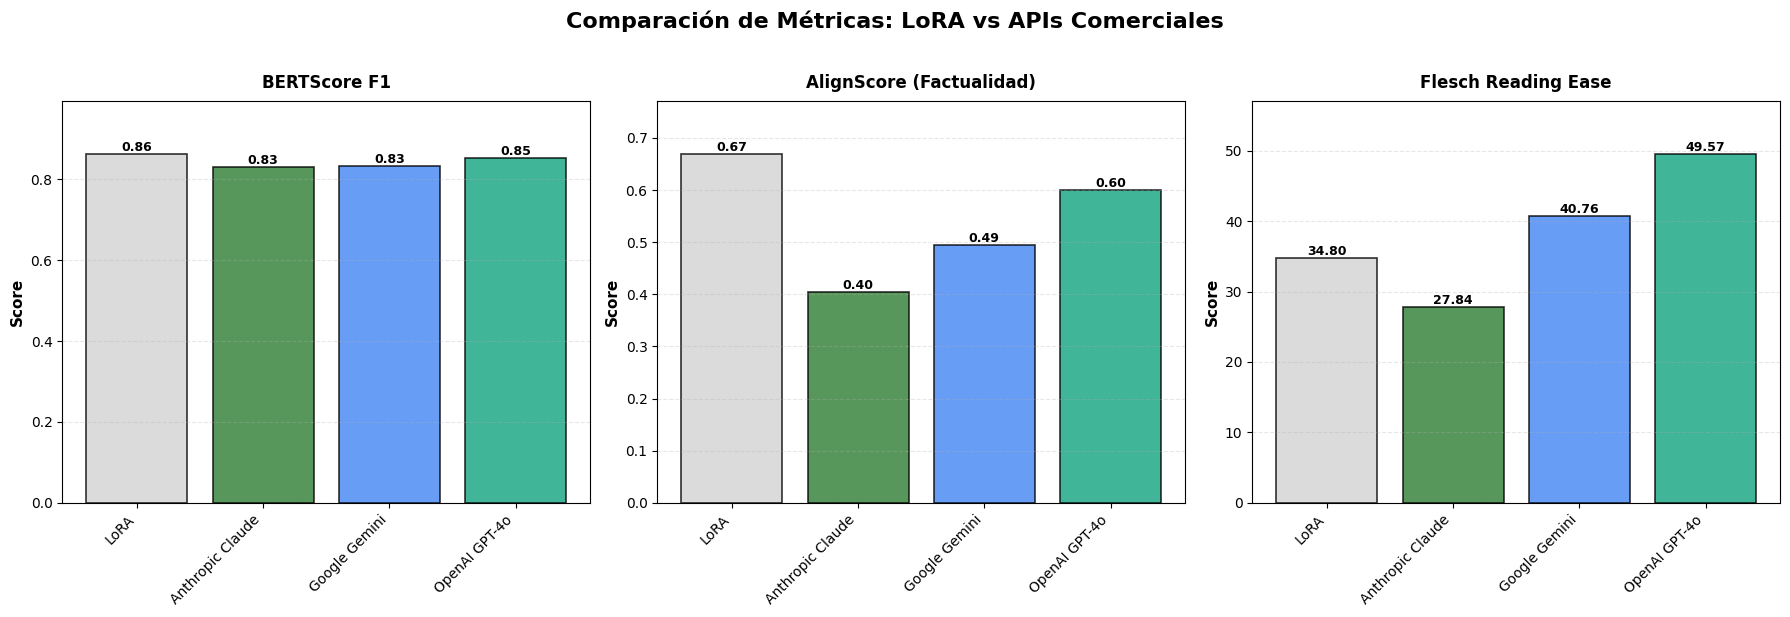

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


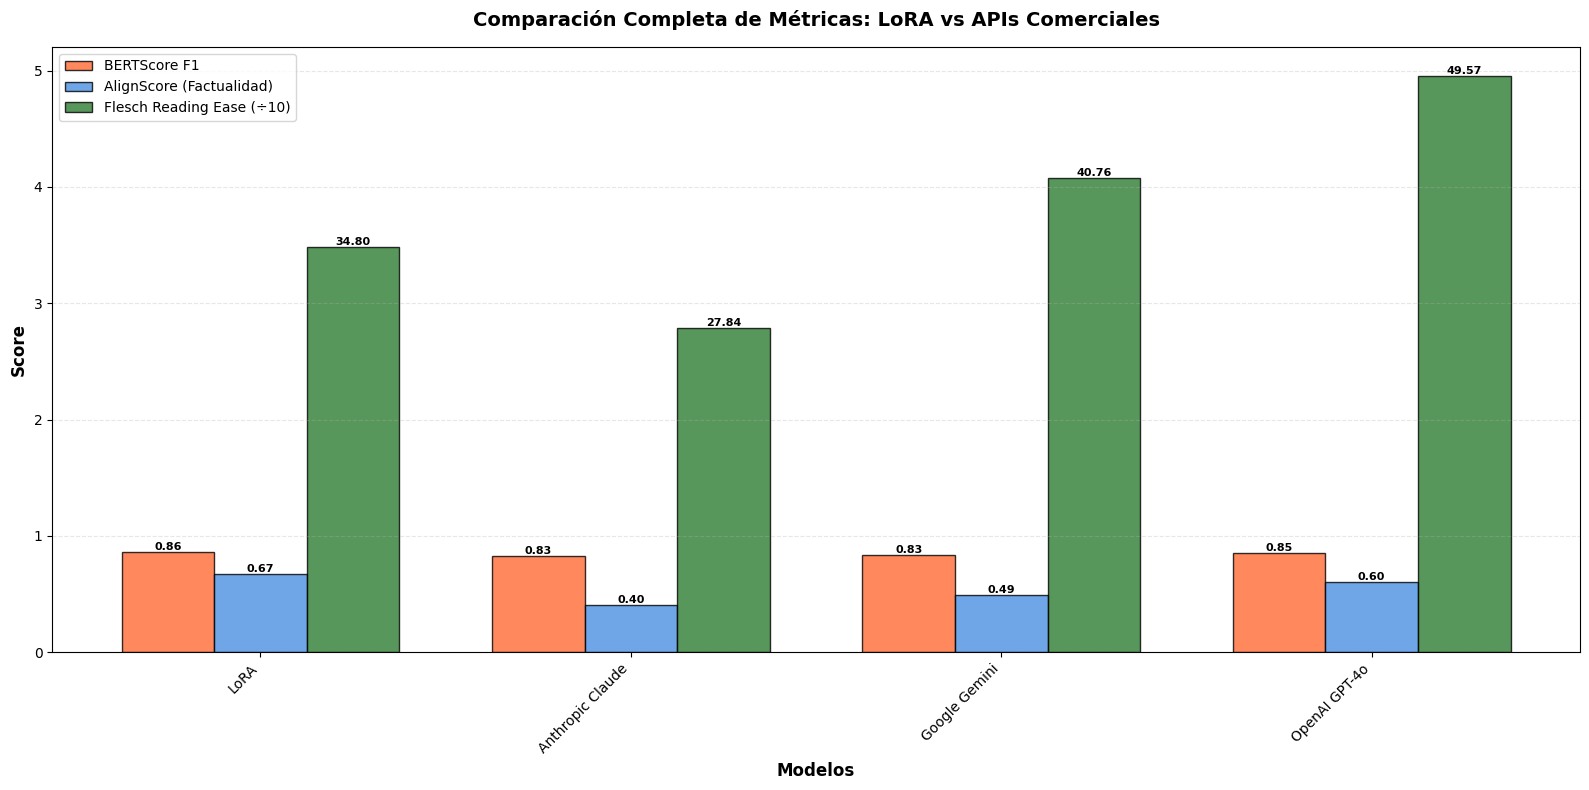


GRÁFICAS GENERADAS
✓ Gráfica 1: Comparación por métrica (3 subplots)
✓ Gráfica 2: Comparación combinada (todas las métricas)

Nota: Flesch Reading Ease está normalizado (÷10) en la gráfica combinada para mejor visualización.


In [ ]:
# ==============================================================
# 8.2 Gráficas comparativas: Modelos locales vs APIs comerciales
# ==============================================================

import matplotlib.pyplot as plt
import numpy as np

# ==============================================================
# SELECCIONAR MODELO LOCAL A COMPARAR
# ==============================================================

MODELO_LOCAL_SELECCIONADO = "LoRA"  # Se escoge el el mejor modelo con el mejor balance

# Preparar datos para las gráficas
metrics_data = {
    "BERTScore F1": {
        # "Base": BASE_MODEL_METRICS["bertscore_f1"],
        # "Base + TD3": BASE_TD3_METRICS["bertscore_f1"],
        # "LoRA": FINETUNED_MODEL_METRICS["bertscore_f1"],
        # "LoRA + TD3": LORA_TD3_METRICS["bertscore_f1"],
    },
    "AlignScore (Factualidad)": {
        # "Base": BASE_MODEL_METRICS["factuality"],
        # "Base + TD3": BASE_TD3_METRICS["factuality"],
        # "LoRA": FINETUNED_MODEL_METRICS["factuality"],
        # "LoRA + TD3": LORA_TD3_METRICS["factuality"],
    },
    "Flesch Reading Ease": {
        # "Base": BASE_MODEL_METRICS["flesch_reading_ease"],
        # "Base + TD3": BASE_TD3_METRICS["flesch_reading_ease"],
        # "LoRA": FINETUNED_MODEL_METRICS["flesch_reading_ease"],
        # "LoRA + TD3": LORA_TD3_METRICS["flesch_reading_ease"],
    },
}

# Agregar el modelo local seleccionado
if MODELO_LOCAL_SELECCIONADO == "Base":
    metrics_data["BERTScore F1"]["Base"] = BASE_MODEL_METRICS["bertscore_f1"]
    metrics_data["AlignScore (Factualidad)"]["Base"] = BASE_MODEL_METRICS["factuality"]
    metrics_data["Flesch Reading Ease"]["Base"] = BASE_MODEL_METRICS["flesch_reading_ease"]
elif MODELO_LOCAL_SELECCIONADO == "Base + TD3":
    metrics_data["BERTScore F1"]["Base + TD3"] = BASE_TD3_METRICS["bertscore_f1"]
    metrics_data["AlignScore (Factualidad)"]["Base + TD3"] = BASE_TD3_METRICS["factuality"]
    metrics_data["Flesch Reading Ease"]["Base + TD3"] = BASE_TD3_METRICS["flesch_reading_ease"]
elif MODELO_LOCAL_SELECCIONADO == "LoRA":
    metrics_data["BERTScore F1"]["LoRA"] = FINETUNED_MODEL_METRICS["bertscore_f1"]
    metrics_data["AlignScore (Factualidad)"]["LoRA"] = FINETUNED_MODEL_METRICS["factuality"]
    metrics_data["Flesch Reading Ease"]["LoRA"] = FINETUNED_MODEL_METRICS["flesch_reading_ease"]
elif MODELO_LOCAL_SELECCIONADO == "LoRA + TD3":
    metrics_data["BERTScore F1"]["LoRA + TD3"] = LORA_TD3_METRICS["bertscore_f1"]
    metrics_data["AlignScore (Factualidad)"]["LoRA + TD3"] = LORA_TD3_METRICS["factuality"]
    metrics_data["Flesch Reading Ease"]["LoRA + TD3"] = LORA_TD3_METRICS["flesch_reading_ease"]

# Agregar APIs comerciales si están disponibles
if ANTHROPIC_METRICS:
    metrics_data["BERTScore F1"]["Anthropic Claude"] = ANTHROPIC_METRICS["bertscore_f1"]
    metrics_data["AlignScore (Factualidad)"]["Anthropic Claude"] = ANTHROPIC_METRICS["factuality"]
    metrics_data["Flesch Reading Ease"]["Anthropic Claude"] = ANTHROPIC_METRICS["flesch_reading_ease"]

if GEMINI_METRICS:
    metrics_data["BERTScore F1"]["Google Gemini"] = GEMINI_METRICS["bertscore_f1"]
    metrics_data["AlignScore (Factualidad)"]["Google Gemini"] = GEMINI_METRICS["factuality"]
    metrics_data["Flesch Reading Ease"]["Google Gemini"] = GEMINI_METRICS["flesch_reading_ease"]

if OPENAI_METRICS:
    metrics_data["BERTScore F1"]["OpenAI GPT-4o"] = OPENAI_METRICS["bertscore_f1"]
    metrics_data["AlignScore (Factualidad)"]["OpenAI GPT-4o"] = OPENAI_METRICS["factuality"]
    metrics_data["Flesch Reading Ease"]["OpenAI GPT-4o"] = OPENAI_METRICS["flesch_reading_ease"]

# Definir colores para cada modelo
model_colors = {
    "Base": "#8B7355",  # Beige/Cream
    "Base + TD3": "#4A90E2",  # Blue
    "LoRA": "#D3D3D3",  # Light Gray
    "LoRA + TD3": "#FF6B35",  # Red/Orange gradient
    "Anthropic Claude": "#2E7D32",  # Green
    "Google Gemini": "#4285F4",  # Google Blue
    "OpenAI GPT-4o": "#10A37F",  # OpenAI Green
}

# Orden de modelos para la gráfica (solo el modelo local seleccionado + APIs comerciales)
model_order = [MODELO_LOCAL_SELECCIONADO]
if ANTHROPIC_METRICS:
    model_order.append("Anthropic Claude")
if GEMINI_METRICS:
    model_order.append("Google Gemini")
if OPENAI_METRICS:
    model_order.append("OpenAI GPT-4o")

# Crear figura con subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f"Comparación de Métricas: {MODELO_LOCAL_SELECCIONADO} vs APIs Comerciales",
             fontsize=16, fontweight='bold', y=1.02)

# Colores para las barras
colors = [model_colors.get(model, "#808080") for model in model_order]

# Graficar cada métrica
for idx, (metric_name, metric_values) in enumerate(metrics_data.items()):
    ax = axes[idx]

    # Obtener valores en el orden correcto
    values = [metric_values.get(model, np.nan) for model in model_order]

    # Crear barras
    bars = ax.bar(range(len(model_order)), values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

    # Agregar valores en las barras
    for i, (bar, val) in enumerate(zip(bars, values)):
        if not np.isnan(val):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.2f}',
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

    # Configurar ejes
    ax.set_xticks(range(len(model_order)))
    ax.set_xticklabels(model_order, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(metric_name, fontsize=12, fontweight='bold', pad=10)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_ylim(0, max([v for v in values if not np.isnan(v)]) * 1.15 if any(not np.isnan(v) for v in values) else 100)

    # Agregar línea de referencia en el valor del modelo Base
    if "Base" in metric_values and not np.isnan(metric_values["Base"]):
        ax.axhline(y=metric_values["Base"], color='gray', linestyle=':', linewidth=1.5, alpha=0.7, label='Base')
        if idx == 0:  # Solo mostrar leyenda en el primer subplot
            ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

# Gráfica combinada (todas las métricas en una sola)
fig2, ax2 = plt.subplots(figsize=(16, 8))

x = np.arange(len(model_order))
width = 0.25  # Ancho de las barras

# Posiciones de las barras para cada métrica
x1 = x - width
x2 = x
x3 = x + width

# Valores para cada métrica
y1 = [metrics_data["BERTScore F1"].get(model, np.nan) for model in model_order]
y2 = [metrics_data["AlignScore (Factualidad)"].get(model, np.nan) for model in model_order]
y3 = [metrics_data["Flesch Reading Ease"].get(model, np.nan) for model in model_order]

# Normalizar Flesch Reading Ease para mejor visualización (dividir por 10)
y3_norm = [v / 10 if not np.isnan(v) else np.nan for v in y3]

# Crear barras
bars1 = ax2.bar(x1, y1, width, label='BERTScore F1', color='#FF6B35', alpha=0.8, edgecolor='black', linewidth=1)
bars2 = ax2.bar(x2, y2, width, label='AlignScore (Factualidad)', color='#4A90E2', alpha=0.8, edgecolor='black', linewidth=1)
bars3 = ax2.bar(x3, y3_norm, width, label='Flesch Reading Ease (÷10)', color='#2E7D32', alpha=0.8, edgecolor='black', linewidth=1)

# Agregar valores en las barras
for bars, values, norm_factor in [(bars1, y1, 1), (bars2, y2, 1), (bars3, y3, 10)]:
    for bar, val in zip(bars, values):
        if not np.isnan(val):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{val:.2f}',
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

# Configurar ejes
ax2.set_xlabel('Modelos', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_title(f'Comparación Completa de Métricas: {MODELO_LOCAL_SELECCIONADO} vs APIs Comerciales',
              fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(model_order, rotation=45, ha='right', fontsize=10)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("GRÁFICAS GENERADAS")
print("="*80)
print("✓ Gráfica 1: Comparación por métrica (3 subplots)")
print("✓ Gráfica 2: Comparación combinada (todas las métricas)")
print("\nNota: Flesch Reading Ease está normalizado (÷10) en la gráfica combinada para mejor visualización.")


In [ ]:
# ==============================================================
# 9. DESCARGAR MODELOS DESDE COLAB
# ==============================================================

import zipfile
import shutil
from google.colab import files, drive
from pathlib import Path

print("="*80)
print("DESCARGAR MODELOS DESDE COLAB")
print("="*80)

# Definir rutas (deben coincidir con las usadas en el notebook)
ADAPTER_DIR = "/content/qwen2.5-3b-pls"
TD3_BASE_DIR = "/content/td3_base_agent"
TD3_LORA_DIR = "/content/td3_lora_agent"

# Verificar qué modelos existen
modelos_disponibles = []

if os.path.exists(ADAPTER_DIR):
    modelos_disponibles.append(("LoRA (Finetuning)", ADAPTER_DIR))
    print(f" Modelo LoRA encontrado en: {ADAPTER_DIR}")
else:
    print(f" Modelo LoRA NO encontrado en: {ADAPTER_DIR}")

if os.path.exists(TD3_BASE_DIR):
    modelos_disponibles.append(("TD3 Base", TD3_BASE_DIR))
    print(f" Agente TD3 Base encontrado en: {TD3_BASE_DIR}")
else:
    print(f" Agente TD3 Base NO encontrado en: {TD3_BASE_DIR}")

if os.path.exists(TD3_LORA_DIR):
    modelos_disponibles.append(("TD3 LoRA", TD3_LORA_DIR))
    print(f" Agente TD3 LoRA encontrado en: {TD3_LORA_DIR}")
else:
    print(f" Agente TD3 LoRA NO encontrado en: {TD3_LORA_DIR}")

if not modelos_disponibles:
    print("\n No se encontraron modelos para descargar.")
    print("Asegúrate de haber ejecutado las celdas de entrenamiento primero.")
else:
    print(f"\n Se encontraron {len(modelos_disponibles)} modelo(s) para descargar.")

    # ==============================================================
    # OPCIÓN 1: Descargar como ZIP
    # ==============================================================
    print("\n" + "="*80)
    print("OPCIÓN 1: DESCARGAR COMO ARCHIVO ZIP")
    print("="*80)

    ZIP_OUTPUT = "/content/modelos_qwen2.5_3b.zip"

    # Crear ZIP con todos los modelos
    with zipfile.ZipFile(ZIP_OUTPUT, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for nombre, ruta in modelos_disponibles:
            if os.path.exists(ruta):
                print(f"Agregando {nombre}...")
                # Agregar todo el directorio al ZIP
                for root, dirs, filenames in os.walk(ruta):
                    for filename in filenames:
                        file_path = os.path.join(root, filename)
                        # Mantener estructura de directorios en el ZIP
                        arcname = os.path.relpath(file_path, os.path.dirname(ruta))
                        arcname = os.path.join(os.path.basename(ruta), arcname)
                        zipf.write(file_path, arcname)

    # Obtener tamaño del archivo
    zip_size_mb = os.path.getsize(ZIP_OUTPUT) / (1024 * 1024)
    print(f"\n✓ ZIP creado: {ZIP_OUTPUT}")
    print(f"  Tamaño: {zip_size_mb:.2f} MB")

    # Descargar el ZIP
    print("\n⬇ Descargando ZIP...")
    files.download(ZIP_OUTPUT)
    print("✓ Descarga iniciada. El archivo se descargará automáticamente.")

    # ==============================================================
    # OPCIÓN 2: Subir a Google Drive (para archivos muy grandes)
    # ==============================================================
    print("\n" + "="*80)
    print("OPCIÓN 2: SUBIR A GOOGLE DRIVE (Opcional)")
    print("="*80)
    print("Si el archivo ZIP es muy grande, puedes subirlo a Google Drive.")
    print("Descomenta las siguientes líneas para usar esta opción:\n")

    print("# Montar Google Drive")
    print("# drive.mount('/content/drive')")
    print("#")
    print("# Copiar ZIP a Drive")
    print("# drive_dest = '/content/drive/MyDrive/modelos_qwen2.5_3b.zip'")
    print("# shutil.copy(ZIP_OUTPUT, drive_dest)")
    print("# print(f'✓ Archivo copiado a: {drive_dest}')")

    # ==============================================================
    # OPCIÓN 3: Descargar modelos individuales
    # ==============================================================
    print("\n" + "="*80)
    print("OPCIÓN 3: DESCARGAR MODELOS INDIVIDUALES (Solo para archivos pequeños)")
    print("="*80)
    print("Nota: Esta opción puede fallar si los archivos son muy grandes.")
    print("Recomendamos usar la OPCIÓN 1 (ZIP) en su lugar.\n")

    print("\n" + "="*80)
    print("RESUMEN")
    print("="*80)
    print(f"✓ ZIP creado con {len(modelos_disponibles)} modelo(s)")
    print(f"✓ Ubicación: {ZIP_OUTPUT}")
    print(f"✓ Tamaño: {zip_size_mb:.2f} MB")
    print("\n Para usar los modelos en otro lugar:")
    print("   1. Descarga el archivo ZIP")
    print("   2. Extrae el contenido")
    print("   3. Carga los modelos usando:")
    print("      - LoRA: model_lora = PeftModel.from_pretrained(base_model, ADAPTER_DIR)")
    print("      - TD3: td3_agent = TD3.load(TD3_DIR, env=env)")
    print("\n" + "="*80)


DESCARGAR MODELOS DESDE COLAB
 Modelo LoRA encontrado en: /content/qwen2.5-3b-pls
 Agente TD3 Base encontrado en: /content/td3_base_agent
 Agente TD3 LoRA encontrado en: /content/td3_lora_agent

 Se encontraron 3 modelo(s) para descargar.

OPCIÓN 1: DESCARGAR COMO ARCHIVO ZIP
Agregando LoRA (Finetuning)...
Agregando TD3 Base...
Agregando TD3 LoRA...

✓ ZIP creado: /content/modelos_qwen2.5_3b.zip
  Tamaño: 11.05 MB

⬇ Descargando ZIP...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Descarga iniciada. El archivo se descargará automáticamente.

OPCIÓN 2: SUBIR A GOOGLE DRIVE (Opcional)
Si el archivo ZIP es muy grande, puedes subirlo a Google Drive.
Descomenta las siguientes líneas para usar esta opción:

# Montar Google Drive
# drive.mount('/content/drive')
#
# Copiar ZIP a Drive
# drive_dest = '/content/drive/MyDrive/modelos_qwen2.5_3b.zip'
# shutil.copy(ZIP_OUTPUT, drive_dest)
# print(f'✓ Archivo copiado a: {drive_dest}')

OPCIÓN 3: DESCARGAR MODELOS INDIVIDUALES (Solo para archivos pequeños)
Nota: Esta opción puede fallar si los archivos son muy grandes.
Recomendamos usar la OPCIÓN 1 (ZIP) en su lugar.


RESUMEN
✓ ZIP creado con 3 modelo(s)
✓ Ubicación: /content/modelos_qwen2.5_3b.zip
✓ Tamaño: 11.05 MB

 Para usar los modelos en otro lugar:
   1. Descarga el archivo ZIP
   2. Extrae el contenido
   3. Carga los modelos usando:
      - LoRA: model_lora = PeftModel.from_pretrained(base_model, ADAPTER_DIR)
      - TD3: td3_agent = TD3.load(TD3_DIR, env=env)



In [ ]:
import json

input_path = "notebook.ipynb"
output_path = "notebook_clean.ipynb"

with open(input_path, "r", encoding="utf-8") as f:
    nb = json.load(f)

# Remove widget metadata safely
if "widgets" in nb.get("metadata", {}):
    del nb["metadata"]["widgets"]

# Also fix cells that contain widget metadata
for cell in nb.get("cells", []):
    if "metadata" in cell and "widgets" in cell["metadata"]:
        del cell["metadata"]["widgets"]

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(nb, f, indent=2)

print("Notebook cleaned →", output_path)
